# Ground Energy Calculation by Direct Iteration

## Explanation
Ground energy calculation using direct iteration is validated by the follwing theorem.

### Theorem
Let $\lambda_j$ be the spectral radius of matrix H. Then,
\begin{eqnarray}
    \lambda_j \sim \frac{\left<\Psi\left|A^{2k+1}\right|\Psi\right>}{\left<\Psi\left|A^{2k}\right|\Psi\right>}.
\end{eqnarray}
for large $k$.
#### Proof

Let $\lambda_i$, $v_i$ be eigenvalues and eigenvectors of matrix $H$ for $i=1,2,..,N$.
\begin{eqnarray}
    A v_i = \lambda_i v_i.
\end{eqnarray}

For arbitary vector w, w could be expanded as
\begin{eqnarray}
    w = \sum_{i=1}^{N} c_i v_i.
\end{eqnarray}
Thus,
\begin{eqnarray}
    A^k w = \sum_{i=1}^{N} c_i \lambda_i^k v_i.
\end{eqnarray}
For large $k$, with $c_j \neq 0$
\begin{eqnarray}
    && \frac{A^k w}{|A^k w|} \to v_j, \nonumber\\
    && where, \max(|\lambda_1|,|\lambda_2|,..,|\lambda_N|) = \lambda_j
\end{eqnarray}

\begin{eqnarray}
    \lambda_j =&& v_j^T A v_j \sim \left(\frac{A^k w}{|A^k w|}\right)^T A \left(\frac{A^k w}{|A^k w|}\right) \nonumber\\
    =&& \frac{\left<w\left|A^{2k+1}\right|w\right>}{\left<w\left|A^{2k}\right|w\right>}
\end{eqnarray}


Since Heisenberg model is the case that groud energy has largest absolute value, we can calculate its ground energy by the theorem.

In [2]:
import numpy as np
from openfermion.linalg import get_sparse_operator
from scipy.linalg import expm

## HOAに必要な関数を定義

In [3]:
from math import factorial

def Derive_q(S:int,K:int):
    """
    solve Simultaneous equations
    returns vector q as numpy.array
    """
    s = (S-1)/2
    M = []
    D = [0]*S
    D[K] = factorial(K)
    for i in range(S):
        M.append([])
        for j in range(S):
            M[-1].append((-s+j)**(i))
    M = np.array(M)
    q = np.linalg.inv(M)@D
    #q = np.round(np.linalg.inv(M)@D,15)
    #print(np.round(M@np.linalg.inv(M),8))
    #print(np.linalg.inv(M))
    #print(M)
    #print(D)
    return q
print(Derive_q(S=7,K=0))

def Propagator(hamiltonian,t:float):
    """
    input hamiltonian as numpy.array
    construct a time evolution of Heisenberg Hamiltonian: U=e^{-iHt}
    returns array of the unitary matrix
    """
    unitary_mtrx = expm(-1j * hamiltonian * t)
    return unitary_mtrx

def H_Diff(S:int,delta:float,hamiltonian,K:int):
    """
    inputs: number of stential points S, distance of stential points, and QubitOperator hamiltonian.
    Construct HOA hamilotonian by size S and distance of neighboring points delta defined in the paper
    returns: array of the HOA hamilotonian
    """
    veq_q = Derive_q(S=S,K=K)
    hamiltonian=get_sparse_operator(hamiltonian).toarray()
    s=(S-1)/2
    H = Propagator(hamiltonian,-s*delta)*veq_q[0]
    for i in range(1,S):
        H+=Propagator(hamiltonian,(-s+i)*delta)*veq_q[i]
    return ((1j/delta)**K) * H

[ 2.98530789e-19 -3.02262424e-18  0.00000000e+00  1.00000000e+00
 -2.41809939e-17  0.00000000e+00  0.00000000e+00]


## Hamiltonian Preparation

In [4]:
from openfermion import QubitOperator
def HeisenbergQubitOperator(J,h,N):
    """
    returns hamiotonian as openfermion.ops.operators.qubit_operator.QubitOperator
    """
    hamiltonian = QubitOperator()
    spin2_list = []
    spin1_list = []

    for i in range(N):
        spin1_list.append("Z{}".format(i))
    for i in range(N-1):
        for j in ["X","Y","Z"]:
            spin2_list.append("{}{} {}{}".format(j,i,j,i+1))
    for i in range(N):
        hamiltonian += -h*QubitOperator(spin1_list[i])
    for i in range(3*(N-1)):
        hamiltonian += -J*QubitOperator(spin2_list[i])
    return hamiltonian

def Heisenberg_Hamiltonian(J,h,N):
    """
    returns Heisenberg hamiltonian as array
    """
    hamiltonian = HeisenbergQubitOperator(J,h,N)
    type(get_sparse_operator(hamiltonian,n_qubits=N))
    hamiltonian = get_sparse_operator(hamiltonian,n_qubits=N).toarray()
    return hamiltonian

def power(mat,n:int):
    if n>=1:
        return power(mat,n-1)@mat
    else:
        return np.eye(len(mat))

## Heisenberg Model

N: Number of spin (=qubits).
\begin{eqnarray}
    H = -J\sum_{i=0}^{N-2}\hat s_{i} \cdot\hat s_{i+1} - h\sum_{i=0}^{N-1}\hat Z_{i}
\end{eqnarray}

By using the relations,
\begin{eqnarray}
    \left<m\right|s_{xy}\left|m\right> = 0 \nonumber\\
    \left<m\right|s_{z}\left|m\right> = (-1)^m \nonumber\\
    for ~ m=0,1
\end{eqnarray}
the ground state is expected to be $\left|00..0\right>$ and the ground energy is 
\begin{eqnarray}
    -J (N-1) -hN.
\end{eqnarray}

> |max energy| < |ground energy| が成り立つ．
ハミルトニアンの各項が次式を満たし，
\begin{eqnarray}
    \sum_{i=0}^{N-1}\hat Z_{i} \geq -N ~~ ,\sum_{i=0}^{N-2}\hat s_{i} \cdot\hat s_{i+1} \geq -(N-1)
\end{eqnarray}
２式の等式が同時に成り立たないため．

In [5]:
N = 6
S = 7
J,h=1,1
delta = 10**-1.75
hamiltonian = HeisenbergQubitOperator(J=J,h=h,N=N)

array_hamil = Heisenberg_Hamiltonian(J=J,h=h,N=N)
val,vec = np.linalg.eig(array_hamil)
idx = val.argsort()
val = val[idx]
vec = vec[:,idx].T
exact_value = np.real(val[0])

## HOA value
list_approx_value = []
#state = np.array([(2**N)**-0.5 for i in range(2**N)])
state = np.random.rand(2**N)
state = state/np.linalg.norm(state)
HOA_hamil = H_Diff(S=S,delta=delta,hamiltonian=hamiltonian,K=1)
for k in range(S):
    state_k = H_Diff(S=S,delta=delta,hamiltonian=hamiltonian,K=k) @ state
    state_k = state_k/np.linalg.norm(state_k)
    approx_value = np.real(state_k.T @ HOA_hamil @ state_k)
    list_approx_value.append(approx_value)
print(list_approx_value)

print(exact_value)

##  ideal value
list_ideal = []
for k in range(S):
    ideal_energy = (state.T @ power(array_hamil,2*k+1) @ state)/(state.T @ power(array_hamil,2*k) @ state)
    list_ideal.append(np.real(ideal_energy))


[-3.4982860962183624, -5.79545568840134, -7.106458808309144, -8.027999019578989, -8.71376480237486, -9.214696359374631, -9.597887083006356]
-11.0


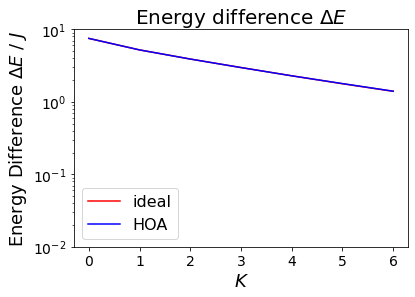

In [6]:
import matplotlib.pyplot as plt

## ideal energy
x=[i for i in range(S)]
y=np.abs(np.array(list_ideal)-exact_value)
plt.plot(x,y,color='red',label="ideal")

## HOA energy
x=[i for i in range(S)]
y=np.abs(np.array(list_approx_value)-exact_value)
plt.plot(x,y,color='blue',label="HOA")

plt.title("Energy difference $\Delta E$",fontsize=20)
plt.xlabel('$K$',fontsize=18)
plt.ylabel('Energy Difference $\Delta E ~ / ~ J$',fontsize=18)
ax = plt.gca()
ax.set_yscale('log')
plt.grid([])
plt.xticks([i for i in range(S)],fontsize=14)
plt.yticks([10**(-2+i) for i in range(4)],fontsize=14)
plt.legend(fontsize=16, loc='lower left')
plt.show()

### 注釈
idealでは，HOAを使わず，Hamiltonianをそのまま代入して期待値を求めた．
論文での結果と異なり，idealとHOAの結果が重なっていない．HOAの結果は論文に近いが，idealが論文と違うように見える．

論文中では$h/J>1$のとき収束しやすいと書かれていたが，それは確認することができた．